#  Générer les statistiques usager

**Description** : Le but de ce notebook est de générer des statistiques sur le suivi des usagers. Un fichier user_statistics a déjà été livré par Motiontag mais celui-ci donne des statistiques sur une période donnée (2023-04-24--2023-06-05), or la date de début et de fin de tracking pour chaque répondant peut être variable. Notre objectif est donc de reproduire le fichier user_statistics par individu.

**Objectifs spécifiques** :
- [ ] Obtenir le nombre de jours avec observation et le nombre de jour non-détecté 
- [ ] Connaître les périodes d'observaiton pour chaque personne
- [ ] Connaître le canton de résidence de chaque répondant·e
- [ ] Ajouter des variables fournies par Motiontag sur les devices

**Résultats attendus** : Un fichier avec une ligne par répondant·e.

**Sous-échantillonnage** :
Tout l'échantillon

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from shapely import geometry, ops
from shapely.geometry import MultiLineString, LineString, Point
import os
import concurrent.futures
from shapely.ops import unary_union
import xyt

import time

from panel_functions import *

### Charger les données

In [4]:
%%time
# Définir le CRS du projet (EPSG:4326 for WGS84)
target_crs = 'EPSG:4326'
print("CRS du projet: WGS84 \n")

#Charger les étapes
legs = pd.read_pickle('../Data/time_space_filters/legs_filtered.pkl')
del legs['canton_dep']
print("Fichier étape chargé")

#Charger les activités
staypoints = pd.read_pickle('../Data/time_space_filters/staypoints_filtered.pkl').reset_index(drop=True)
staypoints = gpd.GeoDataFrame(staypoints, geometry="geometry", crs=target_crs)
print("Fichier activité chargé")


#Charger le questionnaire de la Vague 1 Mobilité pour Domicile déclaré
columns_to_keep = ['longitude_Q14', 'latitude_Q14', 'IDNO', 'Pays', 'Numéro_INSEE', 'Numéro_OFS']
home_declared = pd.read_csv('../../Vague1/EPFL_vague1_v4.csv', low_memory=False, usecols=columns_to_keep)
#Remove those who did not declare any address
home_declared = home_declared[home_declared.longitude_Q14 > 0]
# Create a geometry column from longitude and latitude
geometry = [Point(xy) for xy in zip(home_declared['longitude_Q14'], home_declared['latitude_Q14'])]
# Combine Numéro_INSEE and Numéro_OFS into a single column 'ID_municipality'
home_declared['ID_municipality_survey'] = home_declared.apply(lambda x: x['Numéro_OFS'] if x['Pays'] == '1' else x['Numéro_INSEE'], axis=1)
home_declared = home_declared.drop(columns=['Numéro_OFS', 'Numéro_INSEE', 'longitude_Q14','latitude_Q14'])
# Create a GeoDataFrame
home_declared = gpd.GeoDataFrame(home_declared, geometry=geometry, crs=target_crs)
home_declared = home_declared.rename(columns={'geometry':'home_geometry_from_survey','IDNO':'user_id_fors'})
home_declared = gpd.GeoDataFrame(home_declared, geometry='home_geometry_from_survey', crs=target_crs)
print("Fichier domicile chargé")

#Charger le fichier user_statistics livré par Motiontag mais inexploitable
usr_stat_fors = pd.read_csv('../Data/dumps_fors/UserStatistics.EPFL-Panel.2023-04-24--2023-06-05.csv', sep=';')
usr_stat_motion_tag  = pd.read_csv('../Data/dumps_motiontag/UserStatistics.EPFL-Panel.2023-04-24--2023-06-05.csv', sep=';')
print("Fichier user_statistics chargé (FORS et Motiontag)")

#Charger le fichier de pondération par Alexis Gumy
weights = pd.read_csv('../Data/weights_lasur/data_wgt.csv', sep=',').rename(columns={'IDNO':'user_id_fors'})
w_cols = ['gdr','prof','age_fr','user_id_fors','wgt_cant_gps','wgt_agg_gps','wgt_cant_trim_gps','wgt_agg_trim_gps']
weights = weights[w_cols]
print("Fichier de pondération chargé")

#Charger le questionnaire de la Vague 1 Mobilité
full_survey = pd.read_csv('../../Vague1/EPFL_vague1_v4.csv', low_memory=False)
print("Fichier Questionnaire vague 1 chargé")

#Charger les bases officielles pour le sous-échantillonage géographique https://opendata.swiss/de/dataset/vm-uvek-zones-2017/resource/29b98f2c-42f2-4e72-b8b1-a39500ed0ad0
TAZ = gpd.read_file('../../Vague1/Verkehrszonen_Schweiz_NPVM_2017_shp/Verkehrszonen_Schweiz_NPVM_2017.shp')
TAZ = TAZ[['ID_Agglo', 'N_Agglo', 'N_KT', 'ID_Gem', 'geometry']]
TAZ = TAZ.to_crs(crs=target_crs)
#repare anomalies
TAZ['geometry'] = TAZ['geometry'].buffer(0)
shp_KT = TAZ.dissolve(by='N_KT').reset_index()
print("Fichier Zones de traffic chargé")

CRS du projet: WGS84 

Fichier étape chargé
Fichier activité chargé
Fichier domicile chargé
Fichier user_statistics chargé (FORS et Motiontag)
Fichier de pondération chargé
Fichier Zones de traffic chargé
CPU times: user 16.8 s, sys: 7.9 s, total: 24.7 s
Wall time: 29.2 s


###  Formater les données

In [5]:
staypoints['started_at'] = pd.to_datetime(staypoints['started_at'])
staypoints['finished_at'] = pd.to_datetime(staypoints['finished_at'])

legs['started_at'] = pd.to_datetime(legs['started_at'])
legs['finished_at'] = pd.to_datetime(legs['finished_at'])

staypoints.rename(columns={'IDNO':'user_id', 'id':'activity_id'}, inplace = True)
legs.rename(columns={'IDNO':'user_id', 'id':'leg_id'}, inplace = True)

staypoints['lon'] = staypoints.geometry.x
staypoints['lat'] = staypoints.geometry.y

### Calculer les statistiques par répondant·e

####  Get usr activity statistics based on staypoints

In [6]:
def get_user_activity_stats(staypoints):
    
    # Make a copy to avoid error
    count_act = staypoints.copy()
    
    # Convert 'started_at' column to datetime
    count_act['started_at'] = pd.to_datetime(count_act['started_at'])

    # Extract only the date part
    count_act['date'] = count_act['started_at'].dt.date

    # Group by 'user_id', then find the min and max dates
    user_stats = count_act.groupby('user_id')['date'].agg(['min', 'max']).reset_index()

    # Calculate the total days in the range for each user
    user_stats['days_in_range'] = (pd.to_datetime(user_stats['max']) - pd.to_datetime(user_stats['min'])).dt.days + 1

    # Create a date range covering the entire date range for each user
    date_ranges = user_stats.apply(lambda row: pd.date_range(row['min'], row['max'], freq='D'), axis=1)
    user_stats['date_range'] = date_ranges

   # Group by 'user_id' and count the unique dates
    user_unique_dates = count_act.groupby(['user_id'])['date'].nunique().reset_index()

    # Merge with user_unique_dates to get active_days_count
    user_stats = pd.merge(user_stats, user_unique_dates, on='user_id', how='left')
    user_stats.rename(columns={'date': 'active_days_count'}, inplace=True)

    # Calculate the number of missing days within the range for each user
    user_stats['days_without_event'] = user_stats['days_in_range'] - user_stats['active_days_count']

    # Drop unnecessary columns
    user_stats.drop(columns=['date_range'], inplace=True)

    # Rename the min/may columns
    user_stats.rename(columns={'min':'first_activity_date','max':'last_activity_date','user_id':'user_id_fors'}, inplace=True)

    return user_stats

In [7]:
usr_stats = get_user_activity_stats(staypoints)

In [8]:
usr_stats.days_without_event.value_counts()

days_without_event
0    2806
Name: count, dtype: int64

In [9]:
usr_stats = pd.merge(usr_stats, 
                     get_user_activity_stats(legs).rename(columns={'days_without_event':'days_without_track'})[['user_id_fors','days_without_track']],
                    on='user_id_fors',
                    how='left')

usr_stats.loc[~usr_stats.user_id_fors.isin(legs.user_id.unique().tolist()),'days_without_track'] = 99

usr_stats['days_without_track'] = usr_stats['days_without_track'].astype(int)

In [10]:
usr_stats.days_without_track.value_counts(normalize=True)

days_without_track
0     0.287954
1     0.164647
2     0.103706
3     0.081967
4     0.057377
5     0.049893
6     0.044547
7     0.032074
8     0.028510
9     0.017819
10    0.016037
11    0.012473
12    0.011404
13    0.011048
14    0.008909
15    0.007484
16    0.007484
17    0.007484
19    0.007484
21    0.006058
23    0.006058
20    0.005346
18    0.003920
22    0.003207
25    0.003207
28    0.002138
26    0.001782
24    0.001782
99    0.001782
30    0.001426
29    0.001426
32    0.001069
31    0.000713
27    0.000713
35    0.000356
33    0.000356
36    0.000356
Name: proportion, dtype: float64

#### Add stats on usr's device

In [11]:
merge_on_col = ['operating_system','os_version','handset','confirmed_tracks_count','tracks_count', 'days_in_range_count', 'active_days_count']
usr_stat = usr_stat_motion_tag[['id'] + merge_on_col].merge(usr_stat_fors[['IDNO'] + merge_on_col],
                          how='left',
                          on=merge_on_col)

usr_stat.dropna(subset='IDNO', inplace=True)

# Rename columns
usr_stat.rename(columns={'id': 'user_id_motion_tag', 'IDNO': 'user_id_fors'}, inplace=True)
# Reorder columns
cols = ['user_id_fors','user_id_motion_tag', 'operating_system', 'os_version', 'handset']
usr_stat = usr_stat[cols]

usr_stats = pd.merge(usr_stats,usr_stat,how='left', on='user_id_fors')

#### Add home location from GPS data

In [12]:
%%time 
# Obtenir la localisation du domicile sur la base des données GPS
import pandas as pd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Step 1: Convert the 'geometry' column to Shapely Point objects and remove nans
staypoints_ = staypoints.loc[staypoints.purpose == 'home'].dropna().copy()

# Step 2: Define a function to cluster points within a specified radius using 'lon' and 'lat' columns
def cluster_points(points_, eps, min_samples):
    """
    Clusters points using DBSCAN algorithm.

    Parameters:
        points_ (DataFrame): DataFrame with 'lon' and 'lat' columns.
        eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

    Returns:
        List of cluster labels for each input point.
    """

    points = points_.copy()
    
    scaler = StandardScaler()
    scaled_points = scaler.fit_transform(points[['lon', 'lat']])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(scaled_points)

    return dbscan.labels_

# Step 3: Apply the clustering function to your points
staypoints_['cluster'] = cluster_points(staypoints_, eps=0.00045, min_samples=15)

# Step 4: Define a function to calculate the centroid of each cluster
def calculate_centroid(points):
    """
    Calculates the centroid of a list of points.

    Parameters:
        points (DataFrame): DataFrame with 'lon' and 'lat' columns.

    Returns:
        Centroid Point object.
    """
    centroid_lon = points['lon'].mean()
    centroid_lat = points['lat'].mean()
    return Point(centroid_lon, centroid_lat)

# Step 5: Create a list to store the most recurrent cluster for each user_id
most_recurrent_clusters = []

# Step 6: Calculate the most recurrent cluster for each user_id and store its centroid
for user_id, user_group in staypoints_.groupby('user_id'):
    cluster_counts = user_group['cluster'].value_counts()
    most_recurrent_cluster = cluster_counts.idxmax()
    
    # Get the group of points for the most recurrent cluster
    most_recurrent_group = user_group[user_group['cluster'] == most_recurrent_cluster]
    
    # Calculate the centroid for the most recurrent cluster group
    centroid = calculate_centroid(most_recurrent_group)
    
    most_recurrent_clusters.append({'user_id': user_id, 'centroid': centroid})

# Step 7: Create a new DataFrame from the most_recurrent_clusters list
most_recurrent_clusters_df = pd.DataFrame(most_recurrent_clusters)

# Step 8: Prepare for merging
most_recurrent_clusters_df.rename(columns={'centroid':'home_geometry_from_gps','user_id':'user_id_fors'}, inplace=True)


CPU times: user 3.33 s, sys: 59.6 ms, total: 3.39 s
Wall time: 3.4 s


In [13]:
usr_stats = pd.merge(usr_stats,most_recurrent_clusters_df,how='left', on='user_id_fors')


#### Add home location from declaration in survey

In [14]:
usr_stats = pd.merge(usr_stats,home_declared,how='left', on='user_id_fors')

In [15]:
%%time
usr_stats = gpd.GeoDataFrame(usr_stats, geometry="home_geometry_from_survey", crs=target_crs)
usr_stats = gpd.sjoin(usr_stats, 
                      shp_KT.rename(columns={'N_KT':'KT_home_survey','ID_Agglo':'ID_Agglo_survey','N_Agglo':'N_Agglo_survey'}), 
                      how='left', predicate='intersects')
del usr_stats['index_right']
usr_stats[['ID_Gem','ID_Agglo_survey']] = usr_stats[['ID_Gem','ID_Agglo_survey']].astype(int, errors='ignore') 

usr_stats = gpd.GeoDataFrame(usr_stats, geometry="home_geometry_from_gps", crs=target_crs)
usr_stats = gpd.sjoin(usr_stats, 
                      shp_KT[['N_KT','geometry']].rename(columns={'N_KT':'KT_home_gps'}), 
                      how='left', predicate='intersects')
del usr_stats['index_right']
usr_stats = gpd.GeoDataFrame(usr_stats, geometry="home_geometry_from_survey", crs=target_crs)

CPU times: user 614 ms, sys: 7.56 ms, total: 621 ms
Wall time: 627 ms


In [16]:
usr_stats.loc[usr_stats.user_id_fors.str.startswith('FR'),['KT_home_gps','KT_home_survey','N_Agglo_survey']] = 'FRA'
usr_stats.loc[usr_stats.user_id_fors.str.startswith('FR'),['ID_Agglo_survey','ID_Gem']] = 99

usr_stats['ID_Gem'] = usr_stats['ID_Gem'].fillna(99).astype(int)
usr_stats['ID_Agglo_survey'] = usr_stats['ID_Agglo_survey'].fillna(99).astype(int)

usr_stats['days_with_track'] = usr_stats['active_days_count'] - usr_stats['days_without_track']

In [17]:
reorder_cols = ['user_id_fors', 'user_id_motion_tag', 
 'KT_home_survey', 'KT_home_gps',
 'first_activity_date', 'last_activity_date',
 'days_in_range', 'active_days_count', 'days_without_event','days_with_track','days_without_track', 
 'operating_system','os_version', 'handset', 
 'home_geometry_from_gps', 'home_geometry_from_survey',
 'ID_municipality_survey', 'ID_Agglo_survey', 'N_Agglo_survey']

usr_stats = usr_stats[reorder_cols]
usr_stats = gpd.GeoDataFrame(usr_stats, geometry="home_geometry_from_survey", crs=target_crs)

#### Ajouter les pondérations

In [18]:
usr_stats = pd.merge(usr_stats, weights, on='user_id_fors', how='left')

In [19]:
usr_stats.head()

,user_id_fors,user_id_motion_tag,KT_home_survey,KT_home_gps,first_activity_date,last_activity_date,days_in_range,active_days_count,days_without_event,days_with_track,days_without_track,operating_system,os_version,handset,home_geometry_from_gps,home_geometry_from_survey,ID_municipality_survey,ID_Agglo_survey,N_Agglo_survey,gdr,prof,age_fr,wgt_cant_gps,wgt_agg_gps,wgt_cant_trim_gps,wgt_agg_trim_gps
0,CH01,be168a66-975b-4558-98e8-524c04352039,VD,VD,2023-05-02,2023-06-05,35,35,0,35,0,ios,iOS 16.2,"iPhone14,8",POINT (6.96826 46.31982),POINT (6.96869 46.31997),5401,6153,Monthey,Homme,Population active occupée,30-44 ans,1.422651,1.048683,1.422651,1.048683
1,CH02,76d81957-5f75-422c-8805-84e0506cd985,NaN,VD,2023-04-25,2023-06-05,42,42,0,37,5,ios,iOS 16.2,"iPhone13,4",POINT (6.63444 46.78711),None,NaN,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CH10003,18123160-132f-4293-a11f-45c93ed1855a,VD,VD,2023-04-24,2023-05-31,38,38,0,37,1,android,13,Google Pixel 7 Pro,POINT (6.23072 46.39195),POINT (6.22544 46.39408),5586,6153,Monthey,Homme,Population active occupée,45-59 ans,0.450115,0.271440,0.450115,0.271440
3,CH10039,f7d0f86c-4e05-46f6-a3bf-cc0e501160aa,VD,VD,2023-05-03,2023-06-01,30,30,0,26,4,ios,iOS 16.5,"iPhone14,3",POINT (6.63415 46.78840),POINT (6.64118 46.77847),5938,6153,Monthey,Homme,Population active occupée,45-59 ans,1.196316,1.520423,1.196316,1.520423
4,CH10068,719ee58e-5e33-4c7f-bf58-e6dcef0d4ca3,VD,VD,2023-05-15,2023-06-05,22,22,0,22,0,ios,iOS 16.5,"iPhone13,4",POINT (6.84611 46.45921),POINT (6.84606 46.45861),5890,6153,Monthey,Homme,Population active occupée,30-44 ans,1.202234,0.918514,1.202234,0.918514


#### Ajouter la motorisation des répondant·es

In [66]:
motor_map = {
    1: 'essence',
    2: 'diesel',
    3: 'electrique',
    4: 'hybride rechargeable',
    5: 'hybride nonrechargeable',
    6: 'gaznat_biogaz',
    7: 'GPL'
}

# Selecting columns
motorization = full_survey[['IDNO','Q4_1_1_R', 'Q4_1_2_R', 'Q5_R']].rename(columns={'Q5_R':'main_motor','IDNO':'user_id_fors'}).set_index('user_id_fors').copy()
# Replacing '#NULL!' and '-99' with NaN
motorization.replace(to_replace={'#NULL!': np.nan, '-99': np.nan}, inplace=True)
# Converting columns to float
motorization = motorization.astype(float)
# Summing the columns and creating a new 'car_in_HH' column
motorization['car_in_HH_count'] = motorization[['Q4_1_1_R', 'Q4_1_2_R']].sum(axis=1)
# Dropping the individual columns if needed
motorization.drop(columns=['Q4_1_1_R', 'Q4_1_2_R'], inplace=True)
# Mapping values in 'Q5_R' column
motorization['main_motor'] = motorization['main_motor'].map(motor_map)
# Reset index
motorization = motorization.reset_index()

usr_stats = pd.merge(usr_stats, motorization, on='user_id_fors',how='left')


#### Sauvegarde du fichier user_statistics

In [68]:
usr_stats.to_pickle('../Data/processed_feuille_de_route/gps_user_statistics.pkl')
usr_stats.to_csv('../Data/processed_feuille_de_route/gps_user_statistics.csv')

# Eléments remarquables de user_stats 

In [45]:
len(usr_stats[usr_stats.KT_home_survey != usr_stats.KT_home_gps])

260

In [46]:
usr_stats.KT_home_survey.isna().sum()

99

In [47]:
usr_stats[usr_stats.KT_home_survey == 'GE'].rename(columns={'user_id_fors':'user_id'})

,user_id,user_id_motion_tag,KT_home_survey,KT_home_gps,first_activity_date,last_activity_date,days_in_range,active_days_count,days_without_event,days_without_track,operating_system,os_version,handset,home_geometry_from_gps,home_geometry_from_survey,ID_municipality_survey,ID_Agglo_survey,N_Agglo_survey,gdr,prof,age_fr,wgt_cant_gps,wgt_agg_gps,wgt_cant_trim_gps,wgt_agg_trim_gps
14,CH10223,c0d9bce6-d1f8-4eab-a72c-22e7f2abd1ff,GE,NaN,2023-05-02,2023-06-05,35,35,0,0,ios,iOS 16.4.1,"iPhone14,2",POINT (3.44192 41.59301),POINT (6.13513 46.21089),6621,6621,Genève,Homme,Population active occupée,18-29 ans,0.886180,0.859996,0.886180,0.859996
23,CH10387,e2d5fd7b-cc9c-4f1b-96fb-49736a469803,GE,GE,2023-04-24,2023-05-27,34,34,0,0,ios,iOS 16.4.1,"iPhone12,8",POINT (6.15061 46.19130),POINT (6.15049 46.19122),6621,6621,Genève,Femme,Personnes en formation,18-29 ans,1.008852,0.979043,1.008852,0.979043
25,CH10443,a964a8d4-c1ca-4657-a7ad-a1ea1a3f0516,GE,GE,2023-05-02,2023-06-05,35,35,0,0,ios,iOS 16.5,"iPhone14,3",POINT (6.14537 46.19349),POINT (6.14537 46.19397),6621,6621,Genève,Femme,Population active occupée,45-59 ans,0.604280,0.586425,0.604280,0.586425
26,CH10488,5e786384-b778-490d-9142-47696a3740a9,GE,NaN,2023-04-25,2023-05-30,36,36,0,4,ios,iOS 16.4.1,"iPhone14,7",POINT (8.38707 44.18170),POINT (6.13309 46.21982),6621,6621,Genève,Femme,Personnes sans emploi,45-59 ans,1.170959,1.136360,1.170959,1.136360
27,CH10497,9b4bad52-31ad-41bf-9c10-bcd92db26218,GE,GE,2023-04-24,2023-06-05,43,43,0,7,android,13,OPPO CPH2251,POINT (6.13331 46.18660),POINT (6.13327 46.18633),6608,6621,Genève,Homme,Personnes en formation,18-29 ans,1.645147,1.846118,1.645147,1.846118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,CH9510,34889934-3287-4452-8fa5-864bb87113fa,GE,GE,2023-05-03,2023-06-05,34,34,0,3,ios,iOS 16.0,"iPhone11,8",POINT (6.03378 46.21454),POINT (6.03324 46.21576),6638,6621,Genève,Femme,Population active occupée,45-59 ans,0.522465,0.629670,0.522465,0.629670
2085,CH9596,c4d81257-d608-49d7-970b-16852675d582,GE,GE,2023-04-24,2023-06-05,43,43,0,0,ios,iOS 16.3.1,"iPhone12,1",POINT (6.14124 46.19224),POINT (6.14095 46.19196),6621,6621,Genève,Femme,Population active occupée,18-29 ans,0.860632,0.835203,0.860632,0.835203
2091,CH9639,30a40f2c-50c9-4587-9324-4b5ce46b06f5,GE,GE,2023-04-25,2023-06-01,38,38,0,10,ios,iOS 16.5,"iPhone13,3",POINT (6.12686 46.20534),POINT (6.12637 46.20542),6621,6621,Genève,Femme,Population active occupée,18-29 ans,0.860632,0.835203,0.860632,0.835203
2093,CH97,56593737-c52f-46e5-b485-fa1226d88bec,GE,GE,2023-05-08,2023-06-05,29,29,0,0,ios,iOS 16.1.1,"iPhone14,3",POINT (6.11944 46.18229),POINT (6.11931 46.18246),6628,6621,Genève,Homme,Population active occupée,30-44 ans,0.764730,0.742135,0.764730,0.742135


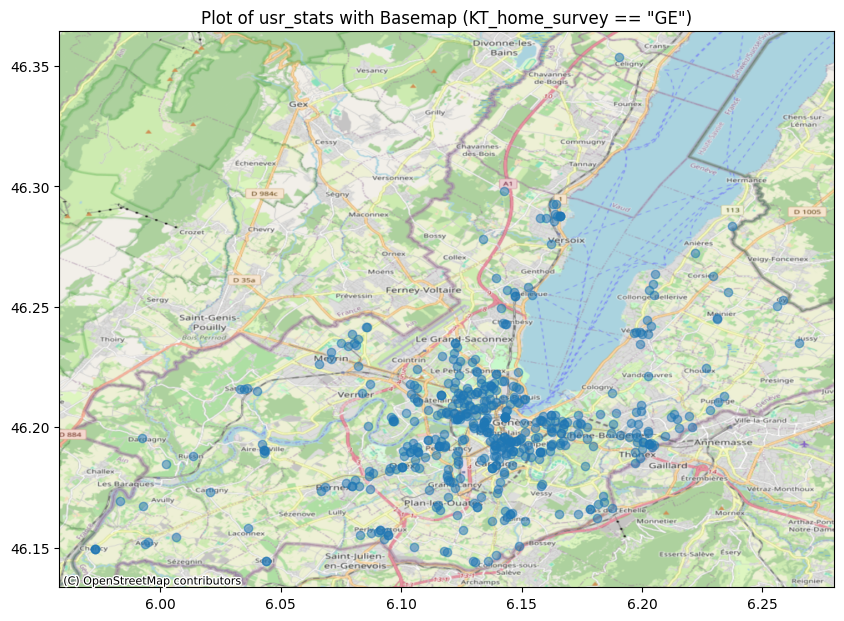

In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Assuming you have usr_stats GeoDataFrame with a column KT_home_survey

# Filter rows where 'KT_home_survey' is equal to 'GE'
usr_stats_filtered = usr_stats[usr_stats['KT_home_survey'] == 'GE']

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame
usr_stats_filtered.plot(ax=ax, alpha=0.5)

# Add a basemap using contextily (OpenStreetMap)
ctx.add_basemap(ax, crs=usr_stats_filtered.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add a title
ax.set_title('Plot of usr_stats with Basemap (KT_home_survey == "GE")')

# Show the plot
plt.show()
